# Intel Image Classification

## Project Workflow:
1. Data Loading and Exploration
  - Data Summary
  - Data Visualization
2. Building Input Pipeline
  - Data Performance Configuration
  - Data Standardization
3. Modeling
  - Simple CNN Model (sCNN)
  - Augmented CNN Model (aCNN)
  - Complex CNN Model based on Pre-trained VGG16 Model (VGG16)
  - Model Comparison
  - Prediction
4. Key Findings and Insights
5. Next Steps


## Data Loading and Exploration

### Data Summary

The data contains around 25k images of Natural Scenes around the world.

All training and testing images with a size of 150x150 are classified into 6 categories:
- buildings = 0
- forest = 1
- glacier = 2
- mountains = 3
- sea = 4
- street = 5

The data consists of 3 separated datasets:
- Train with 14034 images
- Test  with 3000 images
- Prediction with 7301 images

This data was originally published on https://datahack.analyticsvidhya.com by Intel for the Image Classification Competition.

### Import TensorFlow and Other Libraries

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (Rescaling, RandomFlip, RandomRotation, RandomZoom,
                                    Dense, Flatten, Dropout, Conv2D, MaxPooling2D)
from tensorflow.keras.utils import image_dataset_from_directory, plot_model
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.applications import VGG16

### Load and Explore the Datasets

In [ ]:
# Define some basic parameters

batch_size = 32
img_height = 150
img_width = 150

In [ ]:
# Define the path to the datasets directories

train_path = os.path.abspath('seg_train')
test_path = os.path.abspath('seg_test')
pred_path = os.path.abspath('seg_pred')

In [ ]:
# Define data loading function

def load_data(path, labels):
    dataset = image_dataset_from_directory(
        directory=path,
        labels=labels,
        seed=123,
        image_size=(img_height, img_width),
        batch_size=batch_size
    )
    return dataset

In [ ]:
# Load the datasets

train_ds = load_data(train_path, labels='inferred')
test_ds = load_data(test_path, labels='inferred')
pred_ds = load_data(pred_path, labels=None)

Found 14034 files belonging to 6 classes.
Found 3000 files belonging to 6 classes.
Found 7301 files belonging to 1 classes.


In [ ]:
# Explore the image labels

class_names = train_ds.class_names
class_names

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

### Data Visualization

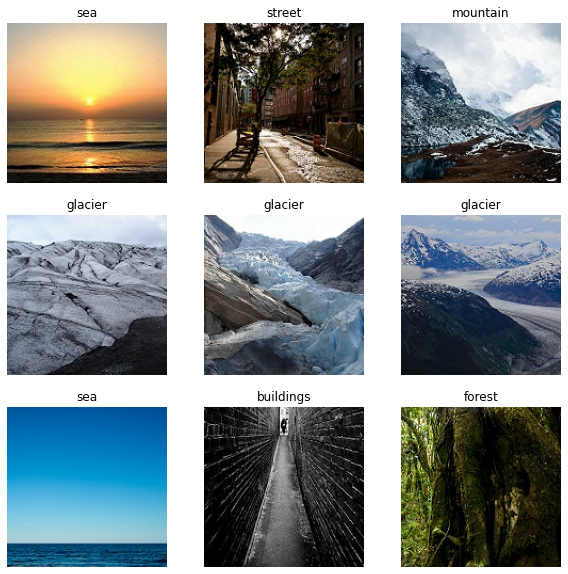

In [ ]:
# Show the first nine images from the training dataset

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

## Building Input Pipeline

### Data Performance Configuration

Two important methods should be used when loading data:

- **Dataset.cache** keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training the model. If the dataset is too large to fit into memory, this method also can be used to create a performant on-disk cache.
- **Dataset.prefetch** overlaps data preprocessing and model execution while training.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
pred_ds = pred_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

### Data Standardization

The RGB channel values are in the **[0, 255]** range. This is not ideal for a neural network.

The values should be standardized to be in the **[0, 1]** range.

In [ ]:
scaling = Rescaling(1. / 255)

train_ds = train_ds.map(lambda x, y: (scaling(x), y))
test_ds = test_ds.map(lambda x, y: (scaling(x), y))
pred_ds = pred_ds.map(lambda x: scaling(x))

## Modeling

### Simple CNN Model (sCNN)

#### Creating the Model 

The Sequential model consists of three convolution blocks with a max pooling layer in each of them.

There's a fully-connected layer with 128 units on top of it that is activated by a ReLU activation function ('relu').

This model is a simple model and has not been tuned for high accuracy.

In [ ]:
sCNN = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(6, activation='softmax')
])

#### Compiling the Model

The Compile method configures the model for training and validation using the optimizer, loss function, and evaluation metrics.

This workflow will use the **Adam** optimizer, the **Sparse Categorical Crossentropy** loss function, and the **Accuracy** evaluation metric.

In [ ]:
sCNN.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

#### Model summary

View all levels of the neural network.

In [ ]:
sCNN.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 20736)             0

#### Training the Model

This workflow will train the model using 10 epochs, and **test_ds** as the validation data.

In [ ]:
epochs = 10

history = sCNN.fit(train_ds, validation_data=test_ds, epochs=epochs)

Epoch 1/10
439/439 [==============================] - 38s 40ms/step - loss: 0.9386 - accuracy: 0.6417 - val_loss: 0.7653 - val_accuracy: 0.7127
Epoch 2/10
439/439 [==============================] - 14s 33ms/step - loss: 0.5759 - accuracy: 0.7872 - val_loss: 0.5842 - val_accuracy: 0.7757
Epoch 3/10
439/439 [==============================] - 15s 33ms/step - loss: 0.4251 - accuracy: 0.8463 - val_loss: 0.5422 - val_accuracy: 0.8093
Epoch 4/10
439/439 [==============================] - 15s 33ms/step - loss: 0.3150 - accuracy: 0.8890 - val_loss: 0.6075 - val_accuracy: 0.8017
Epoch 5/10
439/439 [==============================] - 14s 33ms/step - loss: 0.2108 - accuracy: 0.9285 - val_loss: 0.5891 - val_accuracy: 0.8177
Epoch 6/10
439/439 [==============================] - 14s 33ms/step - loss: 0.1275 - accuracy: 0.9566 - val_loss: 0.7824 - val_accuracy: 0.8003
Epoch 7/10
439/439 [==============================] - 14s 33ms/step - loss: 0.0996 - accuracy: 0.9679 - val_loss: 0.8054 - val_accuracy:

#### Evaluating the Model

Explore the loss and accuracy of validation data after training with 10 epochs.

In [ ]:
sCNN_loss, sCNN_acc = sCNN.evaluate(test_ds, verbose=2)

94/94 - 1s - loss: 1.0929 - accuracy: 0.8193


#### Visualizing Training Results

Create plots of loss and accuracy on the training and validation sets.

In [ ]:
def visualize_results(history, epochs):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower center')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper center')
    plt.title('Training and Validation Loss')
    plt.show();

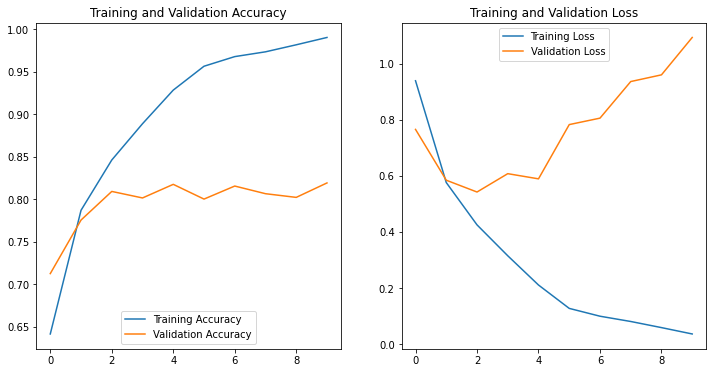

In [ ]:
visualize_results(history, epochs)

#### Conclusion

In the plots above, the training accuracy is increasing linearly over time, whereas validation accuracy stalls around 80% in the training process. Also, the difference in accuracy between training and validation accuracy is noticeable — a sign of overfitting.

When there are a small number of training examples, the model sometimes learns from noises or unwanted details from training examples — to an extent that it negatively impacts the performance of the model on new examples. This phenomenon is known as overfitting. It means that the model will have a difficult time generalizing on a new dataset.

To deal with overfitting in the training process, the base model will be tuned with data augmentation, and Dropout layer will also be added to the model.

### Augmented CNN Model (aCNN)

### Data Augmentation

Data augmentation takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

In [ ]:
# Implement data augmentation using the RandomFlip, RandomRotation and RandomZoom

data_augmentation = Sequential([
    RandomFlip('horizontal', input_shape=(img_height, img_width, 3)),
    RandomRotation(0.1),
    RandomZoom(0.1),
])

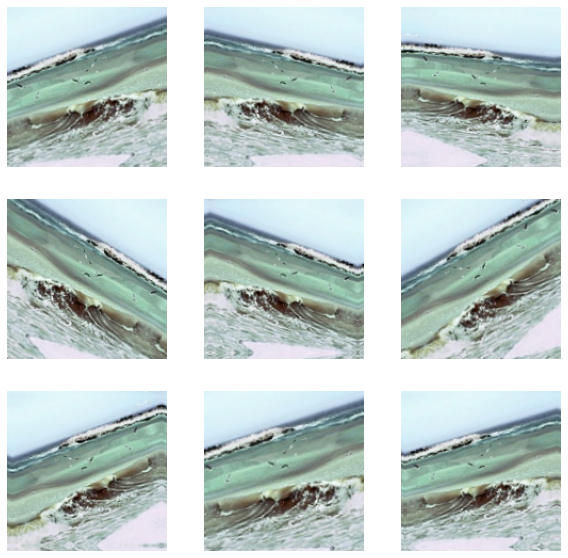

In [ ]:
# Show a few augmented examples applied to the same image several times

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0])
        plt.axis('off')

#### Creating the Model

Create a new model using the **Data Augmentation** approach and **Dropout** layer based on the previous baseline model.

In [ ]:
aCNN = Sequential([
    data_augmentation,
    Conv2D(16, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(6, activation='softmax')
])

#### Compiling and Training the Tuned Model

In [ ]:
# Compile the model

aCNN.compile(optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])

In [ ]:
# View all levels of the model

aCNN.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 150, 150, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 18, 18, 64)       

In [ ]:
# Train the model using 15 epochs and test_ds as the validation data

epochs = 15

history = aCNN.fit(train_ds, validation_data=test_ds, epochs=epochs)

Epoch 1/15
439/439 [==============================] - 18s 39ms/step - loss: 1.0723 - accuracy: 0.5779 - val_loss: 0.9619 - val_accuracy: 0.6613
Epoch 2/15
439/439 [==============================] - 17s 38ms/step - loss: 0.7963 - accuracy: 0.7069 - val_loss: 0.8385 - val_accuracy: 0.7097
Epoch 3/15
439/439 [==============================] - 17s 39ms/step - loss: 0.6909 - accuracy: 0.7440 - val_loss: 0.7284 - val_accuracy: 0.7417
Epoch 4/15
439/439 [==============================] - 17s 39ms/step - loss: 0.6413 - accuracy: 0.7646 - val_loss: 0.6546 - val_accuracy: 0.7707
Epoch 5/15
439/439 [==============================] - 17s 39ms/step - loss: 0.6012 - accuracy: 0.7820 - val_loss: 0.5570 - val_accuracy: 0.8067
Epoch 6/15
439/439 [==============================] - 17s 39ms/step - loss: 0.5657 - accuracy: 0.7956 - val_loss: 0.5837 - val_accuracy: 0.7953
Epoch 7/15
439/439 [==============================] - 17s 39ms/step - loss: 0.5478 - accuracy: 0.8021 - val_loss: 0.5739 - val_accuracy:

#### Evaluating the Model

In [ ]:
aCNN_loss, aCNN_acc = aCNN.evaluate(test_ds, verbose=2)

94/94 - 1s - loss: 0.5518 - accuracy: 0.8207


#### Visualizing Training Results

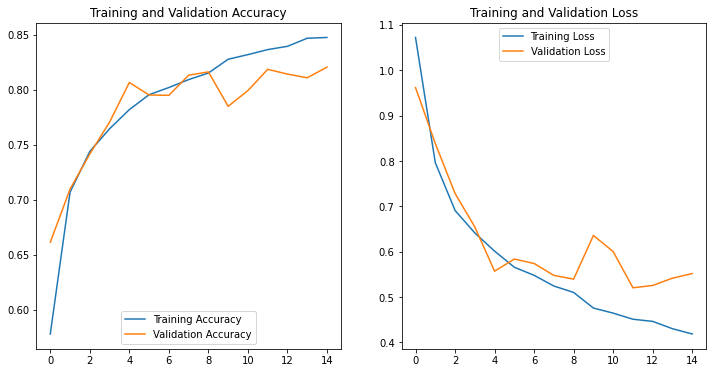

In [ ]:
visualize_results(history, epochs)

#### Conclusion

The plots above show that implementing the data augmentation approach and adding the Dropout layer to the model practically didn't increase the accuracy, but reduced the loss by more than half.

However, the accuracy is still below 85%. This result might be due to the fact that a very simple model was used in this workflow.

Another, more complex model based on the pre-trained VGG16 model will be created to improve accuracy.

### Complex Model based on Pre-trained VGG16 Model (VGG16)

#### Creating the Model

In [ ]:
# Load pre-trained VGG16 model and define its layers as untrainable

pretrained_model=VGG16(input_shape=(img_height, img_width, 3), include_top=False, weights='imagenet')

for layer in pretrained_model.layers:
    layer.trainable = False

In [ ]:
# Explore the last layer of pre-trained model

pretrained_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [ ]:
# Create the complex model

last_layer = pretrained_model.get_layer('block5_pool').output

x = Flatten()(last_layer)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(6, activation='softmax')(x)

vgg16 = Model(pretrained_model.input, x)

#### Compiling and Training the Complex Model

In [ ]:
# Compile the model

vgg16.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

In [ ]:
# View all levels of the model

vgg16.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [ ]:
# Train the model using 10 epochs and test_ds as the validation data

epochs = 10

history = vgg16.fit(train_ds, validation_data=test_ds, epochs=epochs)

Epoch 1/10
439/439 [==============================] - 84s 178ms/step - loss: 0.5712 - accuracy: 0.8026 - val_loss: 0.3528 - val_accuracy: 0.8627
Epoch 2/10
439/439 [==============================] - 71s 162ms/step - loss: 0.3877 - accuracy: 0.8567 - val_loss: 0.3543 - val_accuracy: 0.8640
Epoch 3/10
439/439 [==============================] - 71s 163ms/step - loss: 0.3353 - accuracy: 0.8725 - val_loss: 0.3435 - val_accuracy: 0.8710
Epoch 4/10
439/439 [==============================] - 72s 163ms/step - loss: 0.3007 - accuracy: 0.8896 - val_loss: 0.3321 - val_accuracy: 0.8790
Epoch 5/10
439/439 [==============================] - 72s 163ms/step - loss: 0.2692 - accuracy: 0.8977 - val_loss: 0.3379 - val_accuracy: 0.8747
Epoch 6/10
439/439 [==============================] - 72s 163ms/step - loss: 0.2551 - accuracy: 0.9039 - val_loss: 0.3240 - val_accuracy: 0.8780
Epoch 7/10
439/439 [==============================] - 72s 163ms/step - loss: 0.2420 - accuracy: 0.9088 - val_loss: 0.3354 - val_ac

#### Evaluating the Model

In [ ]:
vgg16_loss, vgg16_acc = vgg16.evaluate(test_ds, verbose=2)

94/94 - 12s - loss: 0.3764 - accuracy: 0.8720


#### Visualizing Training Results

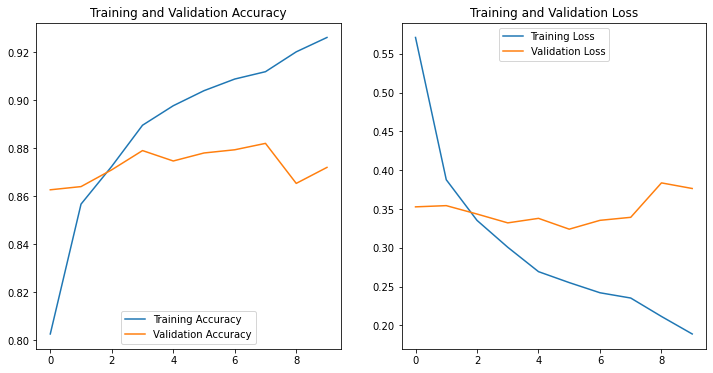

In [ ]:
visualize_results(history, epochs)

#### Conclusion

The plots above show that using the pre-trained complex model significantly improves the result - the accuracy increased by 5%, and the loss decreased almost 3 times, compared to the baseline model.

Unfortunately, there is also a sign of overfitting this time. This indicates that the model needs fine-tuning of the parameters to deal with overfitting and obtain higher accuracy.

### Model Comparison

In [ ]:
# Create a dataframe to compare the model results

data = {
    'Loss': [sCNN_loss, aCNN_loss, vgg16_loss],
    'Accuracy': [sCNN_acc, aCNN_acc, vgg16_acc]
}

models = ['sCNN', 'aCNN', 'VGG16']

evaluation = pd.DataFrame(data, index=models)
evaluation

,Loss,Accuracy
sCNN,1.092877,0.819333
aCNN,0.551755,0.820667
VGG16,0.376446,0.872000


### Prediction

Prediction will be performed on new unlabeled data using VGG16 model.

In [ ]:
# Perform predictions on the new unlabeled data using VGG16 model

predictions = vgg16.predict(pred_ds)

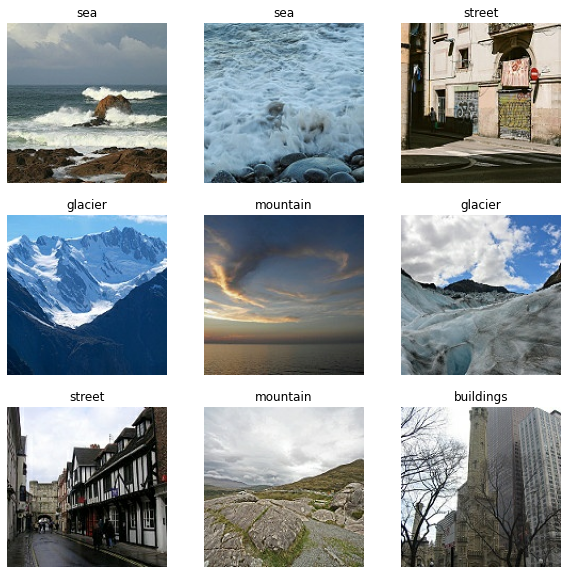

In [ ]:
# Show a sample of predicted images

plt.figure(figsize=(10, 10))
for images in pred_ds.take(1):
    prediction = vgg16.predict(images)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        score = tf.nn.softmax(prediction[i])
        plt.imshow(array_to_img(images[i]))
        plt.title(class_names[np.argmax(score)])
        plt.axis('off')

## Key Findings and Insights

Analyzing the images from the training dataset, it can be noticed that many of them are labeled incorrectly.

The classes that are mostly difficult to classify are **streets** and **buildings**, and **mountains** and **glaciers**.

A basic model with no tuning or optimization is able to provide good accuracy rate (~80%).

Implementing the data augmentation approach and adding the Dropout layer provide slightly better results than the basic model, and also deal with overfitting.

On the other side, the tuned model with the data augmentation approach and Dropout layer provides the same results as the baseline model trained in 3 epochs.

The complex pre-trained VGG16 model provides the best results, but it also needs additional tuning.

## Next Steps

One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the added classifier. The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.

In most convolutional networks, the higher up a layer is, the more specialized it is. The first few layers learn very simple and generic features that generalize to almost all types of images. As you go higher up, the features are increasingly more specific to the dataset on which the model was trained. The goal of fine-tuning is to adapt these specialized features to work with the new dataset, rather than overwrite the generic learning.

Another way is to use other models to train the data, such as InceptionV3 and ResNet50, before fine-tuning the VGG16 model. This will allow to select the best model for further fine-tuning and more accurate prediction on the new data.